In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [14]:
df= pd.read_csv(r"D:\Work file\bd_real_estate\data\processed\processed_data.csv")
df.head(3)

,Unnamed: 0,property_name,address,short_description,price,bedrooms,bathrooms,floor_area,property_url,type,teg
0,0,Flat For Sale In Agargaon Close To Agargaon Ja...,"West Agargaon, Agargaon",lovely apartment is vacant at the moment you g...,8500000.0,3,3,1275.0,https://www.bproperty.com/buy/dhaka/agargaon/f...,buy,agargaon
1,1,We Have A 1133 Sq.Ft Flat For Sale In The Loca...,"West Agargaon, Agargaon",the vacant flat surely is a reasonable deal co...,6231500.0,3,3,1133.0,https://www.bproperty.com/buy/dhaka/agargaon/w...,buy,agargaon
2,2,We Have A 1295 Sq.Ft Flat For Sale In Taltola .,Agargaon,amicable environment appropriate commuting sys...,6500000.0,3,2,1295.0,https://www.bproperty.com/buy/dhaka/agargaon/w...,buy,agargaon


In [25]:
train_df = df.drop(columns=['type','property_url','short_description','short_description','property_name','address',"Unnamed: 0"])

In [26]:
train_df.sample()

,price,bedrooms,bathrooms,floor_area,teg
173,5590000.0,2,2,860.0,dhaka


In [27]:
from sklearn.preprocessing import OrdinalEncoder

# Create a copy of the original data for label encoding
data_label_encoded = train_df.copy()

categorical_cols = train_df.select_dtypes(include=['object']).columns

# Apply label encoding to categorical columns
for col in categorical_cols:
    oe = OrdinalEncoder()
    data_label_encoded[col] = oe.fit_transform(data_label_encoded[[col]])
    print(oe.categories_)

# Splitting the dataset into training and testing sets
X_label = data_label_encoded.drop('price', axis=1)
y_label = data_label_encoded['price']

[array(['Baridara', 'Motijheel', 'agargaon', 'badda', 'banani', 'banasree',
       'bashundora', 'dhaka', 'gulshan', 'keraniganj', 'khilgaon',
       'mirpur', 'mohakhali', 'mohammadpur', 'new-market', 'rampura',
       'tejgaon', 'uttora'], dtype=object)]


In [28]:
y_label

0        8500000.0
1        6231500.0
2        6500000.0
3        6500000.0
4        7800000.0
           ...    
5064    14200000.0
5065     6000000.0
5066     7800000.0
5067     6400000.0
5068    25000000.0
Name: price, Length: 5069, dtype: float64

<Axes: >

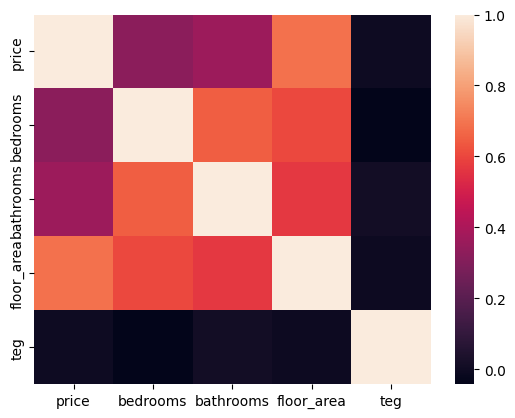

In [29]:
sns.heatmap(data_label_encoded.corr())

In [30]:
fi_df1 = data_label_encoded.corr()['price'].iloc[1:].to_frame().reset_index().rename(columns={'index':'feature','price':'corr_coeff'})
fi_df1

,feature,corr_coeff
0,bedrooms,0.323128
1,bathrooms,0.361652
2,floor_area,0.687159
3,teg,-0.001518


In [31]:
from sklearn.ensemble import RandomForestRegressor

# Train a Random Forest regressor on label encoded data
rf_label = RandomForestRegressor(n_estimators=100, random_state=42)
rf_label.fit(X_label, y_label)

# Extract feature importance scores for label encoded data
fi_df2 = pd.DataFrame({
    'feature': X_label.columns,
    'rf_importance': rf_label.feature_importances_
}).sort_values(by='rf_importance', ascending=False)

fi_df2

,feature,rf_importance
2,floor_area,0.778696
3,teg,0.082493
0,bedrooms,0.075598
1,bathrooms,0.063213


In [32]:
from sklearn.ensemble import GradientBoostingRegressor

# Train a Random Forest regressor on label encoded data
gb_label = GradientBoostingRegressor()
gb_label.fit(X_label, y_label)

# Extract feature importance scores for label encoded data
fi_df3 = pd.DataFrame({
    'feature': X_label.columns,
    'gb_importance': gb_label.feature_importances_
}).sort_values(by='gb_importance', ascending=False)

fi_df3

,feature,gb_importance
2,floor_area,0.637105
0,bedrooms,0.206146
1,bathrooms,0.101490
3,teg,0.055259


In [33]:
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split

X_train_label, X_test_label, y_train_label, y_test_label = train_test_split(X_label, y_label, test_size=0.2, random_state=42)

# Train a Random Forest regressor on label encoded data
rf_label = RandomForestRegressor(n_estimators=100, random_state=42)
rf_label.fit(X_train_label, y_train_label)

# Calculate Permutation Importance
perm_importance = permutation_importance(rf_label, X_test_label, y_test_label, n_repeats=30, random_state=42)

# Organize results into a DataFrame
fi_df4 = pd.DataFrame({
    'feature': X_label.columns,
    'permutation_importance': perm_importance.importances_mean
}).sort_values(by='permutation_importance', ascending=False)

fi_df4

,feature,permutation_importance
2,floor_area,0.307867
0,bedrooms,-0.003247
1,bathrooms,-0.007907
3,teg,-0.009730


In [34]:
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_label)

# Train a LASSO regression model
# We'll use a relatively small value for alpha (the regularization strength) for demonstration purposes
lasso = Lasso(alpha=0.01, random_state=42)
lasso.fit(X_scaled, y_label)

# Extract coefficients
fi_df5 = pd.DataFrame({
    'feature': X_label.columns,
    'lasso_coeff': lasso.coef_
}).sort_values(by='lasso_coeff', ascending=False)

fi_df5


,feature,lasso_coeff
2,floor_area,3.014858e+07
1,bathrooms,1.157687e+06
3,teg,-1.510330e+05
0,bedrooms,-6.238493e+06


In [35]:
from sklearn.feature_selection import RFE

# Initialize the base estimator
estimator = RandomForestRegressor()

# Apply RFE on the label-encoded and standardized training data
selector_label = RFE(estimator, n_features_to_select=X_label.shape[1], step=1)
selector_label = selector_label.fit(X_label, y_label)

# Get the selected features based on RFE
selected_features = X_label.columns[selector_label.support_]

# Extract the coefficients for the selected features from the underlying linear regression model
selected_coefficients = selector_label.estimator_.feature_importances_

# Organize the results into a DataFrame
fi_df6 = pd.DataFrame({
    'feature': selected_features,
    'rfe_score': selected_coefficients
}).sort_values(by='rfe_score', ascending=False)

fi_df6


,feature,rfe_score
2,floor_area,0.788329
0,bedrooms,0.082401
3,teg,0.075238
1,bathrooms,0.054033


In [36]:
from sklearn.linear_model import LinearRegression
# Train a linear regression model on the label-encoded and standardized training data
lin_reg = LinearRegression()
lin_reg.fit(X_scaled, y_label)

# Extract coefficients
fi_df7 = pd.DataFrame({
    'feature': X_label.columns,
    'reg_coeffs': lin_reg.coef_
}).sort_values(by='reg_coeffs', ascending=False)

fi_df7


,feature,reg_coeffs
2,floor_area,3.014858e+07
1,bathrooms,1.157687e+06
3,teg,-1.510331e+05
0,bedrooms,-6.238493e+06
